<a href="https://colab.research.google.com/github/kunalbathija/Udemy-TF-2.0/blob/master/NLP_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

In [0]:
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, \
  Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2020-05-10 15:43:59--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  67.0MB/s    in 2.8s    

2020-05-10 15:44:02 (67.0 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [0]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [0]:
!ls

ml-20m	ml-20m.zip  sample_data


In [0]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [0]:
# We can't trust the userId and movieId to be numbered 0...N-1
# Let's just set our own ids

# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#   global current_user_id, custom_user_map
#   old_user_id = row['userId']
#   if old_user_id not in custom_user_map:
#     custom_user_map[old_user_id] = current_user_id
#     current_user_id += 1
#   return custom_user_map[old_user_id]

# df['new_user_id'] = df.apply(map_user_id, axis=1)

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [0]:
# Now do the same thing for movie ids
# current_movie_id = 0
# custom_movie_map = {} # old movie id > new movie id
# def map_movie_id(row):
#   global current_movie_id, custom_movie_map
#   old_movie_id = row['movieId']
#   if old_movie_id not in custom_movie_map:
#     custom_movie_map[old_movie_id] = current_movie_id
#     current_movie_id += 1
#   return custom_movie_map[old_movie_id]

# df['new_movie_id'] = df.apply(map_movie_id, axis=1)

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [0]:
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values

In [0]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
K = 10

In [0]:
# Make a neural network

# User input
u = Input(shape=(1,))

# Movie input
m = Input(shape=(1,))

# User embedding
u_emb = Embedding(N, K)(u) # output is (num_samples, 1, K)

# Movie embedding
m_emb = Embedding(M, K)(m) # output is (num_samples, 1, K)

# Flatten both embeddings
u_emb = Flatten()(u_emb) # now it's (num_samples, K)
m_emb = Flatten()(m_emb) # now it's (num_samples, K)

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # now it's (num_samples, 2K)

# Now that we have a feature vector, it's just a regular ANN
x = Dense(1024, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
x = Dense(1)(x)

In [0]:
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(lr=0.08, momentum=0.9),
)

In [0]:
# split the data
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# center the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [14]:
r = model.fit(
  x=[train_user, train_movie],
  y=train_ratings,
  epochs=25,
  batch_size=1024,
  verbose=2, # goes a little faster when you don't print the progress bar
  validation_data=([test_user, test_movie], test_ratings),
)

Epoch 1/25
15626/15626 - 154s - loss: 0.7765 - val_loss: 0.7271
Epoch 2/25
15626/15626 - 161s - loss: 0.7009 - val_loss: 0.6960
Epoch 3/25
15626/15626 - 174s - loss: 0.6779 - val_loss: 0.6808
Epoch 4/25
15626/15626 - 166s - loss: 0.6625 - val_loss: 0.6754
Epoch 5/25
15626/15626 - 159s - loss: 0.6525 - val_loss: 0.6752
Epoch 6/25
15626/15626 - 158s - loss: 0.6411 - val_loss: 0.6663
Epoch 7/25
15626/15626 - 160s - loss: 0.6238 - val_loss: 0.6499
Epoch 8/25
15626/15626 - 165s - loss: 0.6094 - val_loss: 0.6421
Epoch 9/25
15626/15626 - 160s - loss: 0.5993 - val_loss: 0.6410
Epoch 10/25
15626/15626 - 159s - loss: 0.5913 - val_loss: 0.6376
Epoch 11/25
15626/15626 - 159s - loss: 0.5834 - val_loss: 0.6361
Epoch 12/25
15626/15626 - 161s - loss: 0.5752 - val_loss: 0.6318
Epoch 13/25
15626/15626 - 164s - loss: 0.5678 - val_loss: 0.6277
Epoch 14/25
15626/15626 - 159s - loss: 0.5614 - val_loss: 0.6265
Epoch 15/25
15626/15626 - 160s - loss: 0.5561 - val_loss: 0.6255
Epoch 16/25
15626/15626 - 158s - l

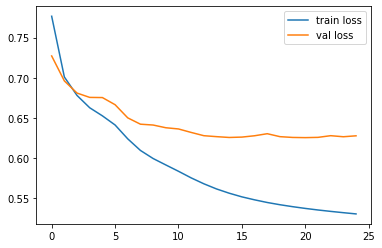

In [15]:
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend()
plt.show()

In [16]:
# is this on par with other approaches?
# https://datascience.stackexchange.com/questions/29740/benchmark-result-for-movielens-dataset
np.sqrt(0.6259)

0.7911384202527394